# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt



In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.set_temp_directory('/scr1/users/dongjp')

In [4]:
tmpmet = core.DDFBinaryMetadata(r"/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv")
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Tue Dec 12 12:57:00 2023


['Intan Input (1)/PortB L Aud Ctx',
 'Intan Input (1)/PortB L Vis Ctx',
 'Intan Input (1)/PortB L Hipp',
 'Intan Input (1)/PortB L Barrel',
 'Intan Input (1)/PortB L Motor',
 'Intan Input (1)/PortB R Motor',
 'Intan Input (1)/PortB R Barrel',
 'Intan Input (1)/PortB R Hipp',
 'Intan Input (1)/PortB R Vis Ctx',
 'Intan Input (1)/PortB R Aud Ctx']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
lan = core.LongRecordingAnalyzer(lrec, 10)

mags = []
phases = []

for i in range(lan.n_fragments // 100):
    if i == 20:
        break
    t = time.process_time()

    # lan.compute_nspike(i)
    # csd = lan.compute_csd(i)
    # plt.imshow(csd['alpha'])

    coh = lan.compute_cohere(i)
    plt.imshow(coh['gamma'])

    pcorr = lan.compute_pcorr(i)
    plt.imshow(pcorr)

    # cacoh = lan.compute_cacoh(i)
    # plt.imshow(cacoh[0])

    # cacoh = lan.compute_cacoh(i, freq_res=1, indices=([[0,1,2,3]], [[4,5,6,7]]))
    # mags.append(cacoh[0])
    # phases.append(cacoh[1])


    # fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    # ax[0].imshow(corr)
    # ax[1].imshow(pcorr)
    # plt.show()

# _, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=True)
# mags = np.stack(mags, axis=-1).mean(axis=-1)
# phases = np.stack(phases, axis=-1).mean(axis=-1)
# ax[0].semilogx(cacoh[2], mags.transpose())
# ax[1].semilogx(cacoh[2], phases.transpose(), c='C1')
# ax[0].set_title("Magnitude")
# ax[1].set_title("Phase")
# plt.show()


In [7]:
Path('./test-wars/A5').resolve()

PosixPath('/home/dongjp/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [8]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
        cores=1,
        memory='16GB',
        processes=1,
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster.scale(jobs=15)  # Scale to 10 workers
client = Client(cluster)
client.upload_file(str(packageroot / 'pythoneeg.zip'))
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.16.8.166:8787/status,
Dashboard: http://172.16.8.166:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.8.166:36803,Workers: 0
Dashboard: http://172.16.8.166:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
# Set up logger with detailed formatting
# logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [10]:
logging.info("Starting job")
logging.warning("This is a warning")
logging.debug("This is a debug message")

2025-03-18 18:16:47,544 - INFO - Starting job
2025-03-18 18:16:47,548 - WARNING - This is a warning


2025-03-18 18:16:47,552 - DEBUG - This is a debug message


In [11]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25']
animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=1)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory

    print("running war")
    war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='dask')
    # war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    print("running sar")
    sar = ao.compute_spike_analysis(multiprocess_mode='dask')

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:153: UserWarning: truncate = True. Only the first 1 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-18 18:16:47,632 - WARNING - Row-major binary files already exist! Skipping existing files


Converting row bins to recs: 100%|██████████| 1/1 [01:37<00:00, 97.34s/it]

running war
2025-03-18 18:18:24,987 - DEBUG - Initializing LongRecordingAnalyzer for /home/dongjp/source-code/PyEEG/notebooks/tests/test-data/A10 KO 12_13_2023
2025-03-18 18:18:24,988 - DEBUG - Processing 31 fragments
2025-03-18 18:18:24,988 - DEBUG - Converting LongRecording to numpy array
2025-03-18 18:18:25,027 - DEBUG - Caching numpy array with h5py in /scr1/users/dongjp/temp_ac7aeaef9db65059da6c1f5e7e20dcf76da869c1856726ad.h5
2025-03-18 18:18:25,154 - DEBUG - Processing metadata serially
2025-03-18 18:18:25,159 - DEBUG - Processing features in parallel


2025-03-18 18:18:33,123 - DEBUG - Cleaning up temp file
2025-03-18 18:18:33,130 - DEBUG - Combining metadata and feature values
2025-03-18 18:18:33,138 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:33,151 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:33,154 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:33,155 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:33,157 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:33,159 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:33,161 - WARNING - Intan Input (1

In [12]:
war = visualization.WindowAnalysisResult.from_pickle_and_json(Path('./test-wars/F22').resolve())

2025-03-18 18:18:35,577 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,580 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,581 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,582 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,582 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,583 - WARNING - Intan Input (1)/PortD D-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,583 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:35,584 - WARNING - Intan

In [13]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdslope,cohere,pcorr,nspike,wavetemp
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73863, 199.99384, 3...","[98233.96, 14860.108, 7970.6455, 37275.63, 151...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2990.8171, 9656.856, 4898.069, 6713.2295, 427...","{'delta': [2371.017, 3296.126, 1211.0659, 2644...","[(-1.6245375548094994, 3.0368814205586463), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98205, 98.85395, 73.50662, 72.37029, 407.4...","[1154.7555, 9768.596, 5399.9824, 5234.5786, 16...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[617.85815, 8765.923, 4538.3516, 4057.7214, 14...","{'delta': [190.04459, 1800.4429, 548.10364, 11...","[(-1.2709592689560614, 2.4014942712763423), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47052, 100.149216, 70.8411, 86.555595, 620...","[1557.7693, 10023.685, 5018.3926, 7481.013, 38...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[808.93463, 7760.562, 3900.8845, 4248.7896, 79...","{'delta': [306.9735, 2821.0764, 938.7143, 2116...","[(-1.4739850325245956, 2.662434533055389), (-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN


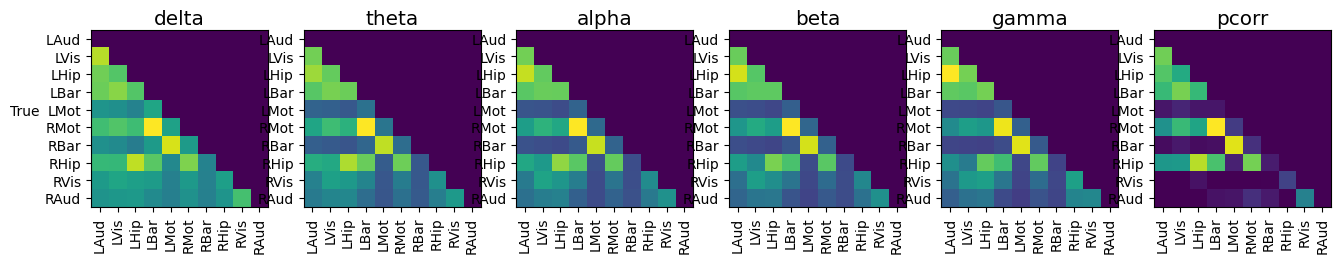

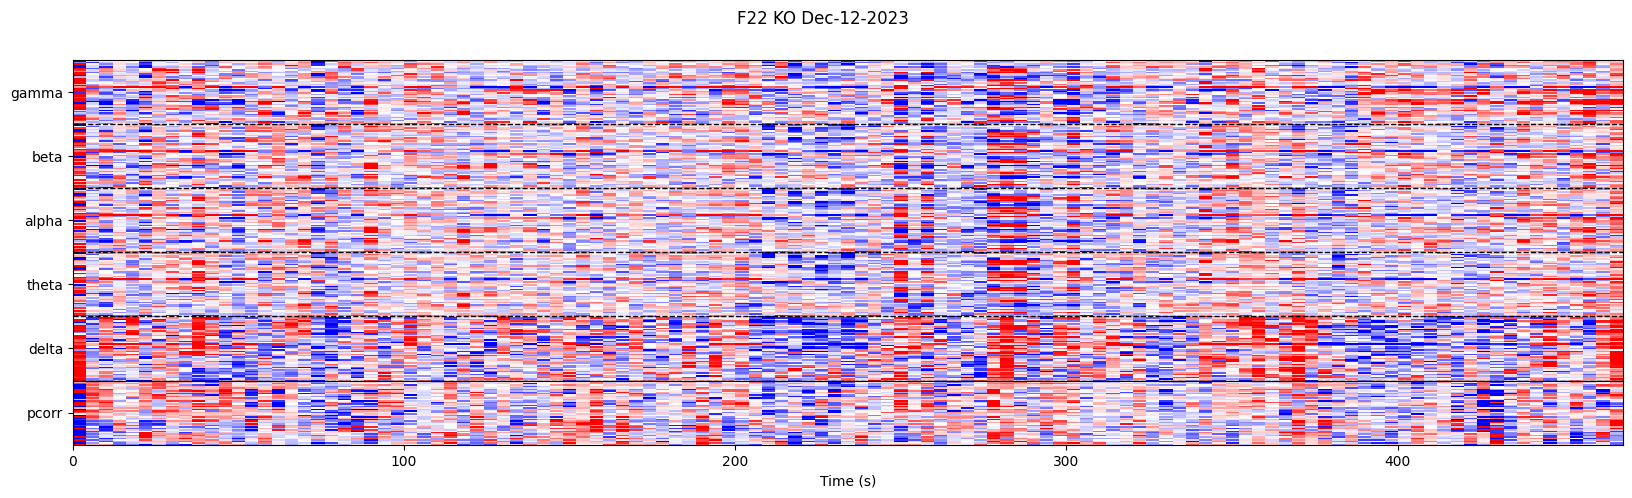

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/animal.py:331: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


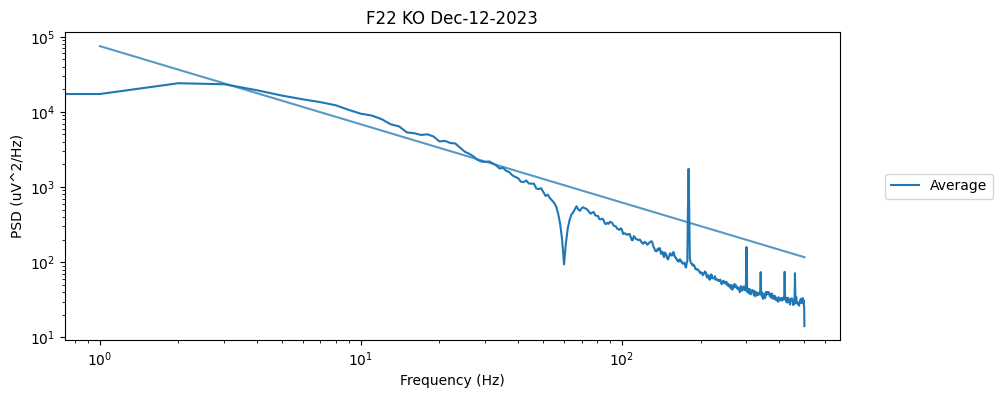

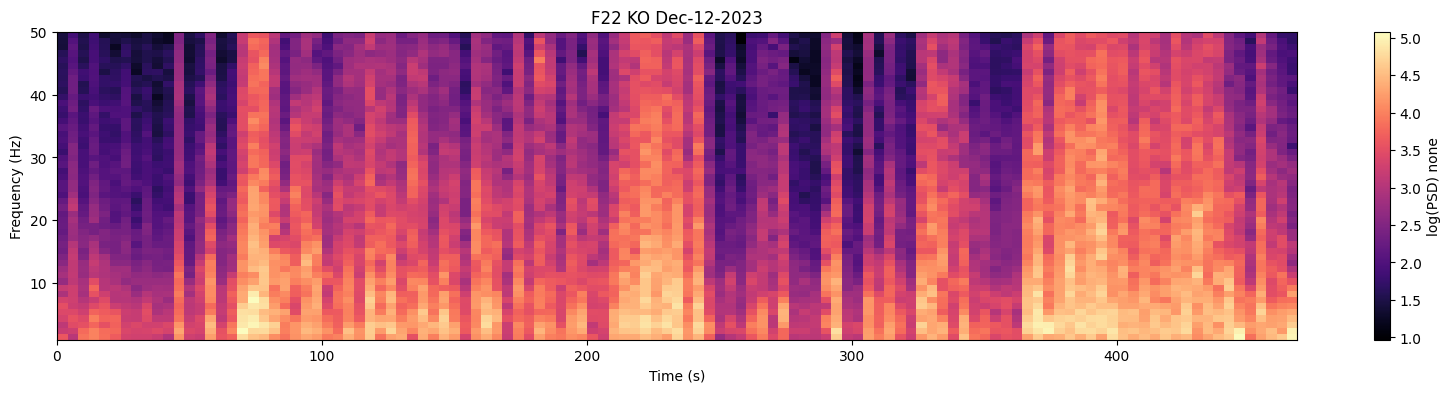

In [14]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

2025-03-18 18:18:38,182 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,191 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,193 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,194 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,195 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,195 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,196 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.


2025-03-18 18:18:38,204 - WARNING - Intan Input (1)/PortC C-019 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,205 - WARNING - Intan Input (1)/PortC C-021 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,206 - WARNING - Intan Input (1)/PortC C-022 does not match name aliases. Assuming alias from number in channel name.
Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
2025-03-18 18:18:38,250 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-18 18:18:38,

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='animal', ylabel='rms'>,
 None)

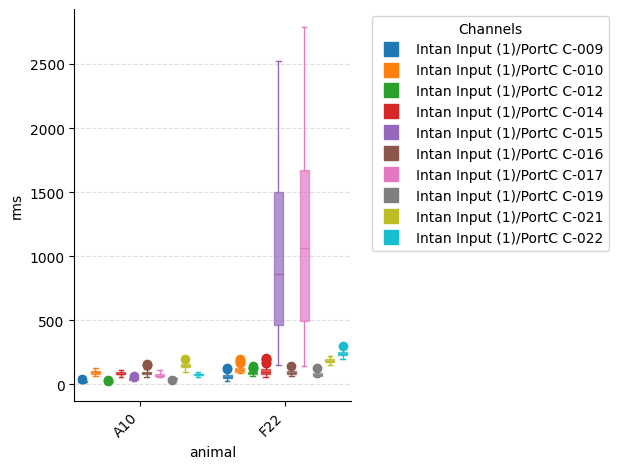

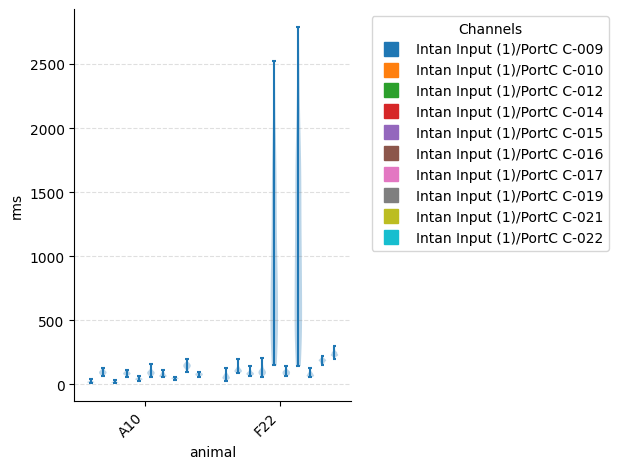

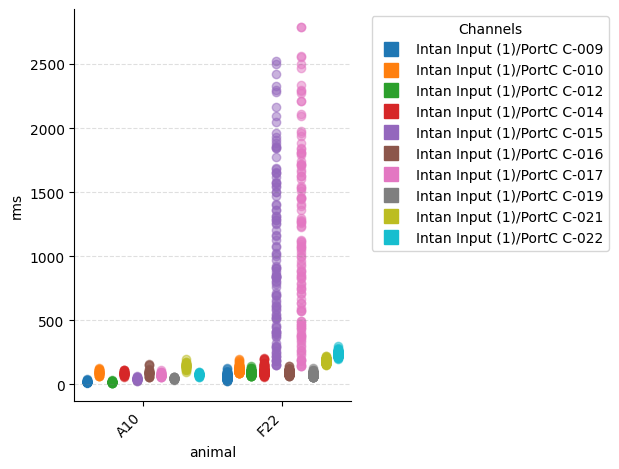

In [15]:
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    wars.append(visualization.WindowAnalysisResult.from_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve()))
ep = visualization.ExperimentPlotter(wars)
ep.plot_boxplot('rms')
ep.plot_violin('rms')
ep.plot_scatter('rms')

In [16]:
# sar[0].result
# visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result)

In [26]:
# quick hack to look at peri-spike EEG
import mne
import matplotlib.colors as colors

def analyze_peri_spike_tfr(mne_obj: mne.io.Raw, tmin=-10, tmax=10, l_freq=1, h_freq=50):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    events, event_dict = mne.events_from_annotations(raw=raw)
    logging.debug(f"Events: {events}")
    logging.debug(f"Event dict: {event_dict}")
    
    # Common parameters for epoch creation
    epoch_params = {
        'raw': raw,
        'preload': True,
        'baseline': None,
        'event_repeated': 'drop'
    }
    
    # Process each spike type separately
    for unit_id in event_dict.keys():
        print(f"Processing unit: {unit_id}")
        
        # Create spike-centered epochs
        epochs_spike = mne.Epochs(
            **epoch_params,
            event_id={unit_id: event_dict[unit_id]},
            tmin=tmin,
            tmax=tmax
        )
        epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Create baseline epochs from whole recording
        epochs_baseline = mne.make_fixed_length_epochs(
            raw, 
            duration=tmax-tmin,
            preload=True
        )
        epochs_baseline.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Ensure we have comparable numbers of epochs
        n_epochs = min(len(epochs_spike), len(epochs_baseline))
        if n_epochs < 1:
            print(f"No valid epochs for unit {unit_id}")
            continue
            
        epochs_spike = epochs_spike[:n_epochs]
        epochs_baseline = epochs_baseline[:n_epochs]
        
        # Compute time-frequency representation
        tfr_params = dict(
            freqs=np.arange(l_freq, h_freq, 1),
            n_cycles=np.arange(l_freq, h_freq, 1) * 2,
            method='multitaper',
            use_fft=True,
            average=True
        )
        
        print("Computing TFR...")
        tfr_spike = epochs_spike.compute_tfr(**tfr_params)
        tfr_baseline = epochs_baseline.compute_tfr(**tfr_params)
        
        # Plot the results
        plot_tfr_ratio(tfr_spike, tfr_baseline)

def plot_tfr_ratio(tfr_spike, tfr_baseline):
    """Plot the ratio between spike and baseline TFR."""
    pow_baseline = np.mean(tfr_baseline.get_data(), axis=(0, 2))
    pow_baseline = pow_baseline[:, np.newaxis]
    pow_spike, plot_t, plot_f = tfr_spike.get_data(return_times=True, return_freqs=True)
    pow_spike = np.mean(pow_spike, axis=0)
    pow_ratio = pow_spike / pow_baseline
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    im = ax.imshow(pow_ratio, aspect='auto',
                   extent=[plot_t[0], plot_t[-1], plot_f[0], plot_f[-1]],
                   origin='lower',
                   cmap=plt.cm.RdBu_r,
                   norm=colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=10))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(0, color='black', linestyle='--')
    plt.colorbar(im, ax=ax, label='Power Ratio (spike/baseline)')
    plt.show()


In [28]:
sar[0]

In [31]:
logger.setLevel(logging.DEBUG)
mne_obj = visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result)
# display(mne_obj)
analyze_peri_spike_tfr(mne_obj)

2025-03-18 18:23:06,241 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-18 18:23:06,253 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-18 18:23:06,268 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-18 18:23:06,278 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-18 18:23:06,293 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 4